In [17]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [18]:
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig1/'
ab = 'mouse_talon_abundance.tsv'
ver = 'vM25_cerberus'
min_tpm = 1
filt_ab = 'cerberus/cerberus_filtered_abundance.tsv'
species = 'mouse'
swan_file = 'swan/swan.p'

swan_meta = 'swan/mouse_metadata.tsv'
read_annot = 'talon/mouse_talon_read_annot.tsv'
ali_table = '../../lr_bulk/ali_sample_table.csv'
file_hr = 'file_to_hr.tsv'

## Supplementary table - library level

In [27]:
# for each library, get the following info

meta = pd.read_csv(file_hr, sep='\t', header=None,
                   names=['ENCODE_file_id', 'dataset'])

# fix dataset names
meta.dataset = meta.dataset.str.replace('-', '_')
meta.dataset = meta.dataset.str.replace('18_20', '18-20')
meta.head()

# add experiment id
df = pd.read_csv('metadata.tsv', sep='\t')
df = df[['File accession', 'Experiment accession']]
df.rename({'File accession': 'ENCODE_file_id',
           'Experiment accession': 'ENCODE_experiment_id'},
           axis=1, inplace=True)
meta = meta.merge(df, on='ENCODE_file_id')

# tissue / cell line, display name
swan_df = pd.read_csv(swan_meta, sep='\t')
swan_df['genotype'] = 'b6'
swan_df.loc[swan_df['sample'].str.contains('c2c12'), 'genotype'] = 'c3h'
swan_df.loc[swan_df['sample'] == 'f1219', 'genotype'] = '129/sv/cast'
swan_df.loc[swan_df.b6cast == True, 'genotype'] = 'b6/cast'
swan_df.loc[swan_df.disease_status == '5x', 'genotype'] = '5xfad'
swan_df = swan_df[['dataset', 'age', 'sex', 'genotype', 'sample', 'classification', 'sample_display']]
meta = meta.merge(swan_df, how='left', on='dataset')
b6n_exps = ['ENCSR926OGQ', ' ENCSR082JMB', 'ENCSR131CES',
           'ENCSR214HSG', 'ENCSR340GWV', 'ENCSR644GDT',
           'ENCSR411ZHA', 'ENCSR804QMV']
meta.loc[meta.ENCODE_experiment_id.isin(b6n_exps), 'genotype'] = 'b6n'


# add sex for missing things
meta.loc[meta['sample'] == 'f1219', 'sex'] = 'f'
meta.loc[meta['sample'].str.contains('c2c12'), 'sex'] = 'f'
meta.loc[meta['ENCODE_experiment_id'] == 'ENCSR942UFC', 'sex'] = 'm'
meta.loc[meta['ENCODE_experiment_id'] == 'ENCSR735IBE', 'sex'] = 'f'

# add hex code
c_dict, order = get_lr_bulk_sample_colors()
meta['sample_color_hex_code'] = meta['sample'].map(c_dict)

# ali's parent tissue / cell line classification
df = pd.read_csv(ali_table)
df.rename({'tissue / cell type':'general_tissue_cell_type'}, axis=1, inplace=True)
df = df.loc[df.species=='Mouse']
df = df[['sample', 'general_tissue_cell_type']].drop_duplicates()
meta = meta.merge(df, how='left', on='sample')

# number of reads post-talon
df = pd.read_csv(read_annot, usecols=[0,1], sep='\t')
df = df.groupby('dataset').count().reset_index()
meta = meta.merge(df, how='left', on='dataset')

# add adult classification

meta.loc[(meta.genotype!='b6cast')&\
       (meta.classification=='tissue')&\
       ~(meta['sample'].str.contains('forelimb')), 'adult'] = True

# other tissues w/ age = 18-20mo and 12mo are adult
ad_ages = ['18-20mo', '12mo', '2mo']
meta.loc[meta.age.isin(ad_ages), 'adult'] = True

# ali's parent tissue / cell line classification
df = pd.read_csv(ali_table)
df.rename({'tissue / cell type':'fig1_tissue_label',
           'read_name': 'reads_post_talon'}, axis=1, inplace=True)
df = df.loc[df.species=='Mouse']
df = df[['sample', 'fig1_tissue_label']].drop_duplicates()
meta = meta.merge(df, how='left', on='sample')

## add human matching samples

# sample to tissue dict for mouse
st_dict = {'adrenal gland': ['adrenal'],
           'heart': ['heart'],
           'muscle': ['gastroc', 'c2c12_myoblast', 'c2c12_myotube', 'forelimb'],
           'brain': ['cortex', 'hippocampus'],
           'pgp1_excite_neuron': ['cortex', 'hippocampus'],
           'pgp1_astro': ['cortex', 'hippocampus'],
           'h9_osteocyte': ['forelimb'],
           'h1': ['f1219'],
           'wtc11': ['f1219']}

df = pd.read_csv('swan/mouse_metadata.tsv', sep='\t')
df = df[['tissue', 'sample']].drop_duplicates()
df = df.groupby('tissue').agg({'sample': ','.join}).reset_index()

from collections import defaultdict
ts_dict = defaultdict(list)
for key, item in st_dict.items():
    for mouse_tissue in item:
        for mouse_sample in df.loc[df.tissue ==mouse_tissue, 'sample'].values[0].split(','):
            ts_dict[mouse_sample].append(key)
               
meta['matching_human_samples'] = meta['sample'].map(ts_dict)

meta.rename({'classification': 'tissue_or_cell_line',
             'read_name': 'reads_post_talon'}, axis=1, inplace=True)

order = ['ENCODE_file_id', 'ENCODE_experiment_id', 'dataset',
         'sample', 'sample_display', 
         'general_tissue_cell_type', 'fig1_tissue_label',
         'age', 'adult', 'sex', 'genotype', 'tissue_or_cell_line', 'sample_color_hex_code',
         'matching_human_samples',
         'reads_post_talon']
meta = meta[order]

meta.to_csv('lr_mouse_library_data_summary.tsv', sep='\t', index=False)

In [26]:
meta.head()

,ENCODE_file_id,ENCODE_experiment_id,dataset,sample,sample_display,general_tissue_cell_type,fig1_tissue_label,age,adult,sex,genotype,tissue_or_cell_line,sample_color_hex_code,matching_human_samples
0,ENCFF684SLZ,ENCSR885NRP,adrenal_18-20mo_m_1,adrenal_18-20mo,Adrenal gland PNM18-20,adrenal gland,adrenal gland,18-20mo,True,m,b6/cast,tissue,#b24422,[adrenal gland]
1,ENCFF643TDK,ENCSR964OKW,gastroc_4d_m_1,gastroc_4d,Gastrocnemius PND4,muscle,muscle,4d,True,m,b6/cast,tissue,#e2e5ef,[muscle]
2,ENCFF821NRP,ENCSR964OKW,gastroc_4d_m_2,gastroc_4d,Gastrocnemius PND4,muscle,muscle,4d,True,m,b6/cast,tissue,#e2e5ef,[muscle]
3,ENCFF800GKP,ENCSR410XGE,heart_18-20mo_m_1,heart_18-20mo,Heart PNM18-20,heart,heart,18-20mo,True,m,b6/cast,tissue,#7caf5c,[heart]
4,ENCFF510KLD,ENCSR410XGE,heart_18-20mo_m_2,heart_18-20mo,Heart PNM18-20,heart,heart,18-20mo,True,m,b6/cast,tissue,#7caf5c,[heart]


## Supplementary table - sample level

In [22]:


# for each sample, get the following info

# tissue / cell line, display name
meta = pd.read_csv(swan_meta, sep='\t')

# number of libraries
meta = meta[['dataset', 'sample', 'classification', 'sample_display']]
meta = meta.groupby(['sample', 'classification', 'sample_display']).count().reset_index()
meta.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)

# add hex code
c_dict, order = get_lr_bulk_sample_colors()
meta['hex_code'] = meta['sample'].map(c_dict)


# ali's parent tissue / cell line classification
df = pd.read_csv(ali_table)
df = df.loc[df.species=='Mouse']
df = df[['sample', 'tissue / cell type']].drop_duplicates()
meta = meta.merge(df, how='left', on='sample')

# number of reads post-talon
df = pd.read_csv(read_annot, usecols=[0,1], sep='\t')
meta2 = pd.read_csv(swan_meta, sep='\t')
meta2 = meta2[['sample', 'dataset']]
df = df.merge(meta2, how='left', on='dataset')
df = df.groupby('sample').count().reset_index()
df.rename({'read_name': 'n_reads'}, axis=1, inplace=True)
meta = meta.merge(df, how='left', on='sample')




In [25]:
meta.to_csv('lr_mouse_data_summary.tsv', sep='\t', index=False)

In [28]:
## How many libraries / ali tissue do we have?
meta = pd.read_csv('lr_mouse_data_summary.tsv', sep='\t')
meta = meta[['n_libraries', 'tissue / cell type']].groupby('tissue / cell type').sum().reset_index()
meta.to_csv('lr_mouse_libraries_per_ali_tissue.tsv', sep='\t')

## legend

In [12]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=1,
               ver=ver,
               species=species,
               gene_subset='polya')

sg = swan.read(swan_file)

# by sample
adata = sg.adata[:, tids]
len(adata.var.index)

# color
# add colors
# map values in order specific to
obs_col = 'sample'
cmap, order = get_lr_bulk_sample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors
order = [o for o in order if o in sample_order]

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450


Trying to set attribute `.obs` of view, copying.


Read in graph from swan/swan.p


In [13]:
# df = pd.read_csv('swan/mouse_metadata.tsv', sep='\t')
# df = df[['sample', 'sample_display', 'classification']]
# df = df.drop_duplicates()
# adata.obs = adata.obs.merge(df, on='sample', how='left')
print(adata.obs.head())

                                         dataset  total_counts  b6cast  \
index                                                                    
hippocampus_18-20mo_m_2  hippocampus_18-20mo_m_2      775207.0    True   
cortex_18-20mo_m_1            cortex_18-20mo_m_1      816172.0    True   
hippocampus_18-20mo_f_2  hippocampus_18-20mo_f_2      573073.0    True   
adrenal_18-20mo_f_1          adrenal_18-20mo_f_1     1164071.0    True   
adrenal_10d_m_2                  adrenal_10d_m_2     1026248.0    True   

                              tissue      age sex  rep 5x_v_wt disease_status  \
index                                                                           
hippocampus_18-20mo_m_2  hippocampus  18-20mo   m  2.0     NaN            NaN   
cortex_18-20mo_m_1            cortex  18-20mo   m  1.0     NaN            NaN   
hippocampus_18-20mo_f_2  hippocampus  18-20mo   f  2.0     NaN            NaN   
adrenal_18-20mo_f_1          adrenal  18-20mo   f  1.0     NaN            Na

['adrenal_4d', 'adrenal_10d', 'adrenal_14d', 'adrenal_25d', 'adrenal_36d', 'adrenal_2mo', 'adrenal_18-20mo', 'hippocampus_14d', 'hippocampus_2mo', 'hippocampus_18-20mo', 'cortex_14d', 'cortex_2mo', 'cortex_18-20mo', 'gastroc_4d', 'gastroc_10d', 'gastroc_14d', 'gastroc_25d', 'gastroc_36d', 'gastroc_2mo', 'gastroc_18-20mo', 'heart_14d', 'heart_2mo', 'heart_18-20mo', 'c2c12_myoblast', 'c2c12_myotube', 'forelimb_e11', 'forelimb_e13', 'adrenal', 'hippocampus', 'cortex', 'f1219']
display_order
['Adrenal gland PND4', 'Adrenal gland PND10', 'Adrenal gland PND14', 'Adrenal gland PND25', 'Adrenal gland PND36', 'Adrenal gland PNM2', 'Adrenal gland PNM18-20', 'Hippocampus PND14', 'Hippocampus PNM2', 'Hippocampus PNM18-20', 'Cortex PND14', 'Cortex PNM2', 'Cortex PNM18-20', 'Gastrocnemius PND4', 'Gastrocnemius PND10', 'Gastrocnemius PND14', 'Gastrocnemius PND25', 'Gastrocnemius PND36', 'Gastrocnemius PNM2', 'Gastrocnemius PNM18-20', 'Heart PND14', 'Heart PNM2', 'Heart PNM18-20', 'C2C12', 'C2C12-deri

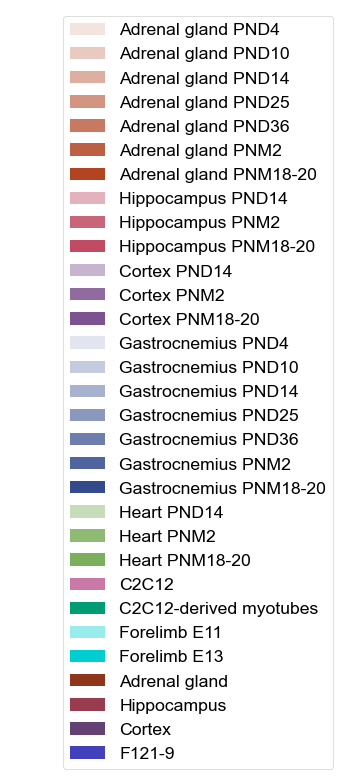

In [14]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

df = adata.obs.copy(deep=True)
df = df[['sample', 'sample_display']].drop_duplicates()
c_dict_2 = {}
for key, item in cmap.items():
    try:
        key2 = df.loc[df['sample'] == key, 'sample_display'].values[0]
        c_dict_2[key2] = item
    except:
        pass
# order = adata.obs['sample'].cat.categories
display_order = [df.loc[df['sample']==s, 'sample_display'].values[0] for s in order]
print(order)
print('display_order')
print(display_order)
df['sample_display'] = df['sample_display'].astype('category')
df['sample_display'].cat.categories = display_order
import matplotlib.patches as patches
samples = []
for s in display_order:
    c = c_dict_2[s]
    samples.append(patches.Rectangle((0,0),1,1,facecolor=c))
ax = sns.scatterplot()
plt.legend(samples, df.sample_display.cat.categories)

ax.set_xticklabels('')
ax.set_yticklabels('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fname = f'{fig_dir}/mouse_lr_bulk_samples.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

In [ ]:
# df = pd.read_csv('swan/mouse_metadata.tsv', sep='\t')
# print(df.head())
# df = df[['sample', 'sample_display', 'classification']]
# df = df.drop_duplicates()
# df = df.sort_values(by=['classification', 'sample_display'], ascending=True)
# # order = df.sample_display.tolist()
# order = []
# df['number'] = [i for i in range(len(df.index))]


# obs_col = 'sample'
# cmap, order = get_lr_bulk_sample_colors()
# adata.obs[obs_col] = adata.obs[obs_col].astype('category')
# obs_order = list(adata.obs_names)
# sample_order = adata.obs[obs_col].cat.categories.tolist()
# sample_colors = [cmap[s] for s in sample_order]
# adata.uns['{}_colors'.format(obs_col)] = sample_colors
# order = [o for o in order if o in sample_order]



# c_dict_2 = {}
# for key, item in c_dict.items():
#     try:
#         key2 = df.loc[df['sample'] == key, 'sample_display'].values[0]
#     except:
#         pass
#     c_dict_2[key2] = item
# df['sample_display'] = df['sample_display'].astype('category')
# df['sample_display'].cat.categories = order
# import matplotlib.patches as patches
# samples = []
# for s in df.sample_display.cat.categories:
#     c = c_dict_2[s]
#     samples.append(patches.Rectangle((0,0),1,1,facecolor=c))
# ax = sns.scatterplot()
# plt.legend(samples, df.sample_display.cat.categories)

# ax.set_xticklabels('')
# ax.set_yticklabels('')

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# fname = f'{fig_dir}/mouse_lr_bulk_samples.pdf'
# plt.savefig(fname, dpi=700, bbox_inches='tight')

    
# # ax = sns.catplot(data=df, x='number', y='number',
# #             hue='sample_display', palette=c_dict_2, order=order)


## Umaps

In [31]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=1,
               ver=ver,
               species=species,
               gene_subset='polya')

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450


In [32]:
sg = swan.read(swan_file)

Read in graph from swan/swan.p


Trying to set attribute `.obs` of view, copying.
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is d

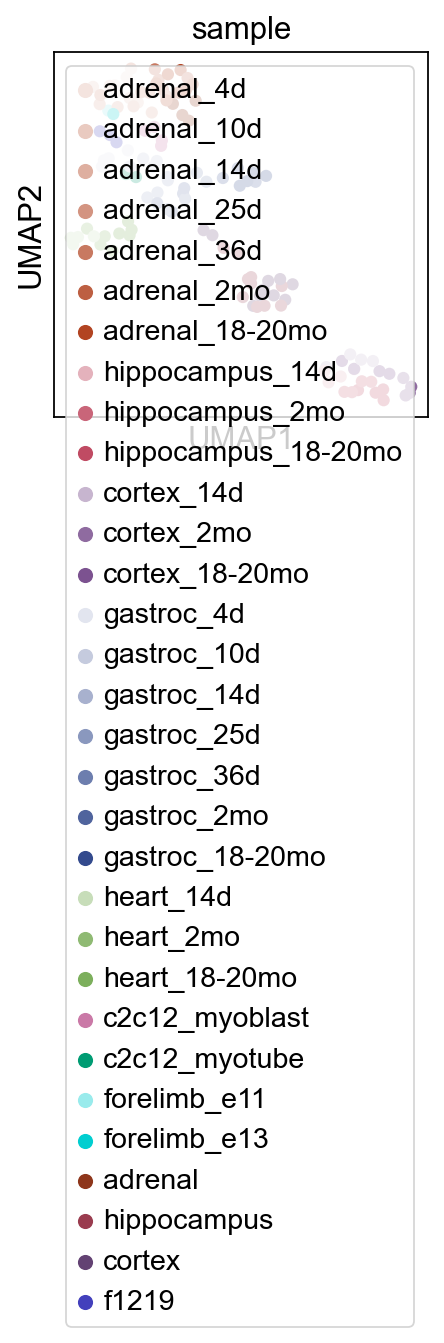

In [34]:



# by sample
adata = sg.adata[:, tids]
len(adata.var.index)

# color
# add colors
# map values in order specific to
obs_col = 'sample'
cmap, order = get_lr_bulk_sample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors
order = [o for o in order if o in sample_order]
# adata.obs[obs_col].cat.reorder_categories(order, inplace=True)


# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

sc.pl.umap(adata, color='sample', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/mouse_lr_umap.pdf', dpi=500, bbox_inches='tight')
f.savefig(fig_dir+'mouse_lr_umap.pdf', dpi=500, bbox_inches='tight')



handles, labels = plt.gca().get_legend_handles_labels()
order_inds = dict([(labels[i], i) for i in range(len(labels))])
order = [order_inds[sample] for sample in order]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

# plt.gca().legend(bbox_to_anchor=(1.1, 1.05))


f = plt.gcf()
f.savefig('figures/mouse_lr_umap_legend.pdf', dpi=500, bbox_inches='tight')
f.savefig(fig_dir+'mouse_lr_umap_legend.pdf', dpi=500, bbox_inches='tight')



In [ ]:
sg.adata.obs.tissue.unique()

Trying to set attribute `.obs` of view, copying.


['cell_line', 'tissue', 'brain']
{'cell_line': '#7680e8', 'tissue': '#e39f24', 'brain': '#b0799a'}
['brain', 'cell_line', 'tissue']
['brain', 'tissue', 'cell_line']
Categories (3, object): ['brain', 'cell_line', 'tissue']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version

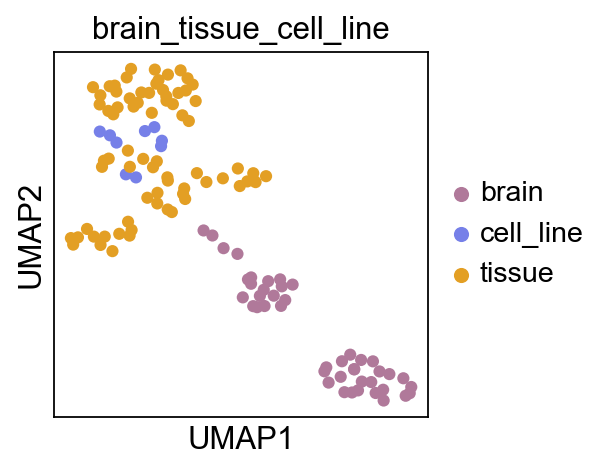

In [35]:

# make the figure square
sc.set_figure_params(figsize=(3,3))

# by cell line, tissue, brain
adata = sg.adata[:, tids]
len(adata.var.index)

obs_col = 'brain_tissue_cell_line'
adata.obs[obs_col] = 'tissue'
adata.obs.loc[adata.obs['sample'].isin(['c2c12_myoblast', 'c2c12_myotube', 'f1219']), obs_col] = 'cell_line'
adata.obs.loc[adata.obs['sample'].str.contains('hippo'), obs_col] = 'brain'
adata.obs.loc[adata.obs['sample'].str.contains('cortex'), obs_col] = 'brain'

# add colors
# map values in order specific to
cmap, order = get_tissue_cell_line_colors()
cmap2, _ = get_biosample_colors()
brain_color = cmap2['brain'] 
order += ['brain']
print(order)
cmap['brain'] = brain_color
print(cmap)
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
print(sample_order)
print(adata.obs[obs_col].unique())
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# normalize data matrix to 10,000 count
sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 70000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

sc.pl.umap(adata, color=obs_col, frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/mouse_lr_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')
f.savefig(fig_dir+'mouse_lr_umap_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')


## Read length plots

In [ ]:
fig_dir = '/Users/fairliereese/Documents/programming/mortazavi_lab/documents/rnawg/fig1/'

In [37]:
meta.head()

,dataset,b6cast,tissue,age,sex,rep,5x_v_wt,disease_status,forelimb,c2c12,f1219,adrenal,sample,hr,classification,sample_display
0,adrenal_gland_2_1,False,adrenal,NaN,NaN,NaN,False,NaN,False,False,False,True,adrenal,adrenal_gland_2_1,tissue,Adrenal gland
1,adrenal_gland_2_2,False,adrenal,NaN,NaN,NaN,False,NaN,False,False,False,True,adrenal,adrenal_gland_2_2,tissue,Adrenal gland
2,adrenal_gland_1_1,False,adrenal,NaN,NaN,NaN,False,NaN,False,False,False,True,adrenal,adrenal_gland_1_1,tissue,Adrenal gland
3,adrenal_gland_1_2,False,adrenal,NaN,NaN,NaN,False,NaN,False,False,False,True,adrenal,adrenal_gland_1_2,tissue,Adrenal gland
4,adrenal_10d_m_2,True,adrenal,10d,m,2.0,NaN,NaN,NaN,NaN,NaN,NaN,adrenal_10d,adrenal_10d_m_2,tissue,Adrenal gland PND10


In [38]:
## read lengths

# read lengtrhs
df = pd.read_csv(read_annot, usecols=[1,8], sep='\t') 


In [39]:
# tissue / cell line designation
meta = pd.read_csv(swan_meta, sep='\t')
cell_lines = meta.loc[meta.classification == 'cell_line', 'dataset'].tolist()
tissues = meta.loc[meta.classification == 'tissue', 'dataset'].tolist()
df['source'] = False
df.loc[df.dataset.isin(cell_lines), 'source'] = 'Reads from cell lines'
df.loc[df.dataset.isin(tissues), 'source'] = 'Reads from tissues'

In [40]:
t_df, _, _ = get_gtf_info('iso',
                          ver='vM25_cerberus',
                          subset='polya')

In [41]:
df = df[['read_length', 'source']]
df.rename({'read_length': 'length'}, axis=1, inplace=True)
# df['source'] = 'Reads'
t_df = t_df[['t_len']]
t_df.rename({'t_len':'length'}, axis=1, inplace=True)
t_df['source'] = 'GENCODE vM25 transcripts'
df = pd.concat([df, t_df])

In [43]:
xlim = 10000

<Figure size 240x240 with 0 Axes>

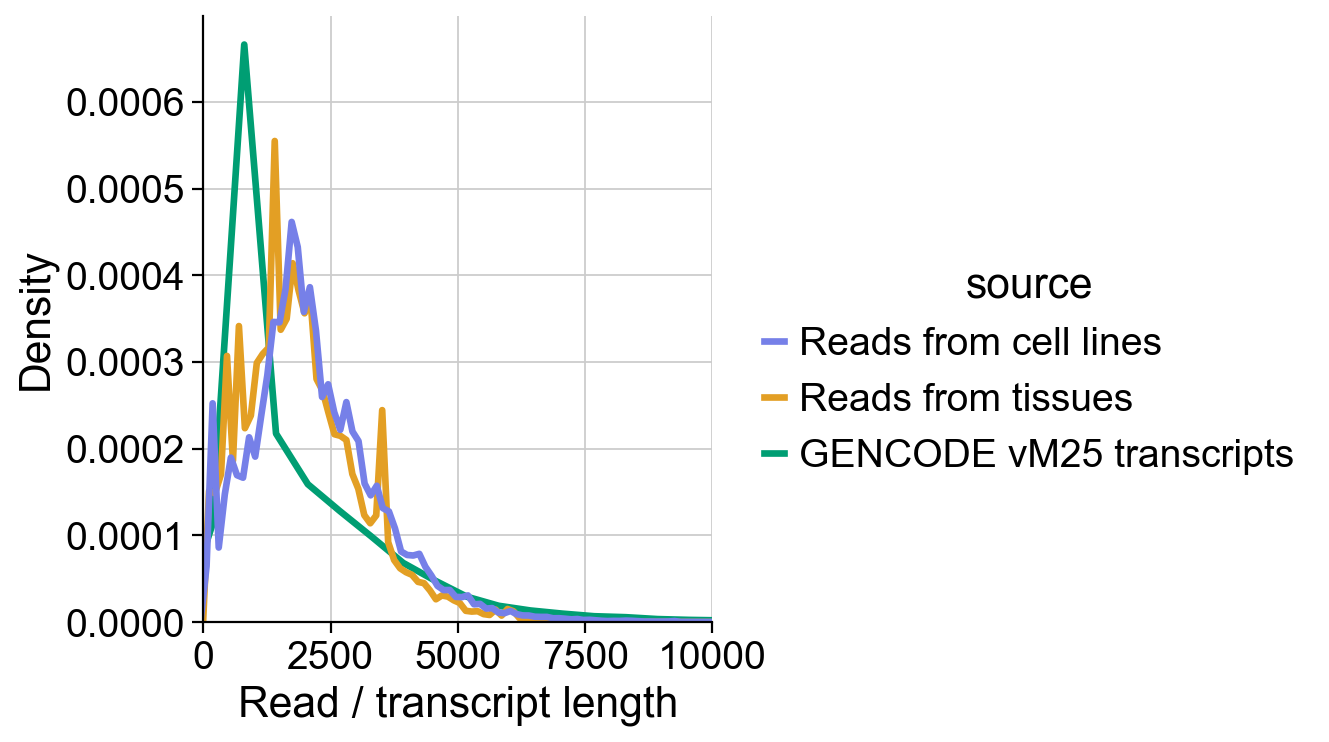

In [44]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,3))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

temp_c_dict, order = get_ic_nov_colors()
c_dict = dict()
c_dict['GENCODE vM25 transcripts'] = temp_c_dict['Known']
temp_c_dict, order = get_tissue_cell_line_colors()
c_dict['Reads from tissues'] = temp_c_dict['tissue']
c_dict['Reads from cell lines'] = temp_c_dict['cell_line']
order = ['Reads from cell lines',
         'Reads from tissues',
         'GENCODE vM25 transcripts']

ax = sns.displot(data=df, x='length', kind='kde',
                     linewidth=3, common_norm=False, hue='source',
                     palette=c_dict, hue_order=order)
xlabel = 'Read / transcript length'
ylabel = 'Density'

if xlim:
    _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,xlim))
else:
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)

# plt.vlines(5000, ymin=0, ymax=5.5, colors='gray', linestyles='dashed')
fname = f'{fig_dir}/mouse_read_vs_transcript_len.png'
plt.savefig(fname, dpi=500, bbox_inches='tight')
fname = f'{fig_dir}/mouse_read_vs_transcript_len.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')